## Initial Definitions

In [21]:
import ROOT as r
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
import colorsys
from scipy import optimize as sciopt
import os


## Set-Up Histograms

In [42]:
"""
Import bigass histograms with all the endgame data, and get the energy projections you want
"""

f = r.TFile("../endgame/EndgameData90Percent.root")

energy_range = [2500, 3200]

calo_hists = []

for i in range(1, 25):
    calo = f.Get("verticalPosition/clusters" + str(i)).Clone("calo_" + str(i))
    
    calo.SetAxisRange(energy_range[0], energy_range[1], "y")
    calo_hists.append(calo.Project3D("zx"))
    
    
# make some quadrants why not

quadrants = []

for j in range(0, 24, 6):
    hist_list = r.TList()
    hist_list.Add(calo_hists[j+1])
    hist_list.Add(calo_hists[j+2])
    hist_list.Add(calo_hists[j+3])
    hist_list.Add(calo_hists[j+4])
    hist_list.Add(calo_hists[j+5])
    
    q = calo_hists[j].Clone("quadrant_"+str(j//6 + 1))
    q.Merge(hist_list)
    quadrants.append(q)

In [3]:
quadrants

[<ROOT.TH2D object ("quadrant_1") at 0x7fffe14f25e0>,
 <ROOT.TH2D object ("quadrant_2") at 0x7fffe0717fc0>,
 <ROOT.TH2D object ("quadrant_3") at 0x7fffe0f70580>,
 <ROOT.TH2D object ("quadrant_4") at 0x7fffe14e6f10>]

## Plotting Functions

In [4]:
def plot_fit_results(data2, fig_name, mean_lim=[None, None], sd_lim=[None, None], fit_lim=[0, 700]):
    """
    Plots the fit results for a dataframe with columns:
    
    ['TimeBin', 'GausConst', 'GausMean', 'GausMeanError',
     'GausSD', 'GausSDError', 'ChiSquare', 'HistMean',
     'HistMeanError', 'HistSD', 'HistSDError', 'Npoints',
     'RMS', 'Skewness', 'RMSError', 'GausConst_ns',
     'GausMean_ns', 'GausMeanError_ns', 'GausSD_ns',
     'GausSDError_ns', 'ChiSquare_ns']
    
    Saves plot in png fig_name.png
    
    data2:    [DataFrame] a pandas dataframe with the stuff to plot
    fig_name: [str] the desired name of the figure
    mean_lim: [list] a 2 valued list containing the lower and upper ylim for the mean graph
                     Defaults to [None, None], which will let matplotlib set limits automatically
    sd_lim:   [list] a 2 valued list containing the lower and upper ylim for the standard deviation graph
                     Defaults to [None, None], which will let matplotlib set limits automatically
    fit_lim:  [list] a 2 valued list containing the lower and upper time limits for fitting. Defaults
                     to over the entire 700μs fill
    """
    
    data = data2[(data2['TimeBin'] > 30) & (data2['TimeBin'] < 700) & (data2['GausMean'] < 6)][:]
    
    # convert from crystal units to mm
    
    data['HistMean']         = (data['HistMean'] - 3) * 25.2
    data['GausMean']         = (data['GausMean'] - 3) * 25.2
    data['GausMean_ns']      = (data['GausMean_ns'] - 3) * 25.2
    
    data['HistMeanError']    = data['HistMeanError'] * 25.2
    data['GausMeanError']    = data['GausMeanError'] * 25.2
    data['GausMeanError_ns'] = data['GausMeanError_ns'] * 25.2
    data['HistSD']           = data['HistSD'] * 25.2
    data['GausSD']           = data['GausSD'] * 25.2
    data['GausSD_ns']        = data['GausSD_ns'] * 25.2
    data['HistSDError']      = data['HistSDError'] * 25.2
    data['GausSDError']      = data['GausSDError'] * 25.2
    data['GausSDError_ns']   = data['GausSDError_ns'] * 25.2
    
    
    fig, ax = plt.subplots(3, 2)
    fig.set_size_inches(18, 12)
    
    # --------------------------
    # Hist Stats
    # --------------------------
    
    # restrict the data for fitting to be within a predefined time range
    fit_data = data[(data['TimeBin'] > fit_lim[0]) & (data['TimeBin'] < fit_lim[1])][:]
        
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1,
                            full=True, w=1/fit_data['HistMeanError'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1,
                            full=False, cov=True, w=1/fit_data['HistMeanError'])
        
    line = linear_func(coeff[0], coeff[1], fit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))
    
    # mean
    
    ax[0, 0].plot(data['TimeBin'], data['HistMean'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Histogram Stat');
    ax[0, 0].plot(fit_data['TimeBin'], fit_data['HistMean'], linestyle='None', marker='o', color='xkcd:green', markersize=2, label='Included in Slope Fit');
    ax[0, 0].errorbar(data['TimeBin'], data['HistMean'], yerr=data['HistMeanError'], color='xkcd:blue', elinewidth=1, fmt='none');
    ax[0, 0].plot(line[0], line[1], color='xkcd:green', linewidth=1, label='({0:.2e}±{2:.2e})*x + {1:.2f}±{3:.2f}'.format(coeff[0], coeff[1], param_errors[0], param_errors[1]));
    ax[0, 0].plot(0, 0, linestyle='none', label='Chi2 / dof = {0:.2f}'.format(chisq_dof))
    
    ax[0, 0].set_ylabel('Mean Y (mm)');
    ax[0, 0].set_xlabel('Time (μs)');
    ax[0, 0].legend(loc=0,shadow=True);
    ax[0, 0].set_ylim(mean_lim[0], mean_lim[1]);
    ax[0, 0].set_title('Mean Y From Histogram');
    
    # restrict the data for fitting to be within a predefined time range
    fit_data = data[(data['TimeBin'] > fit_lim[0]) & (data['TimeBin'] < fit_lim[1]) & (data['HistSD'] > 0)][:]
        
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['HistSD'], 1,
                            full=True, w=1/fit_data['HistSDError'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['HistSD'], 1,
                            full=False, cov=True, w=1/fit_data['HistSDError'])
        
    line = linear_func(coeff[0], coeff[1], fit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))
    
    ax[0, 1].plot(data['TimeBin'], data['HistSD'], linestyle='none', marker='o',
                  color='xkcd:blue', markersize=4, label='Histogram Stat');
    ax[0, 1].plot(fit_data['TimeBin'], fit_data['HistSD'], linestyle='None', marker='o',
                  color='xkcd:green', markersize=2, label='Included in Slope Fit');
    ax[0, 1].errorbar(data['TimeBin'], data['HistSD'], yerr=data['HistSDError'],
                      color='xkcd:blue', elinewidth=1, fmt='none')
    ax[0, 1].plot(line[0], line[1], color='xkcd:green', linewidth=1,
                  label='({0:.2e}±{2:.2e})*x + {1:.2f}±{3:.2f}'.format(coeff[0], coeff[1], param_errors[0], param_errors[1]));
    ax[0, 1].plot(0, 0, linestyle='none', label='Chi2 / dof = {0:.2f}'.format(chisq_dof))
    
    ax[0, 1].set_ylabel('RMS (mm)');
    ax[0, 1].set_xlabel('Time (μs)');
    ax[0, 1].legend(loc=0,shadow=True);
    ax[0, 1].set_ylim(sd_lim[0], sd_lim[1]);
    ax[0, 1].set_title('RMS From Histogram');
    
    thing = [coeff[0], param_errors[0], coeff[1], param_errors[1], chisq_dof]

    # --------------------------
    # with the spikes
    # --------------------------
    
    # mean
    
    # restrict the data for fitting to be within a predefined time range
    fit_data = data[(data['TimeBin'] > fit_lim[0]) & (data['TimeBin'] < fit_lim[1])][:]
        
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['GausMean'], 1,
                            full=True, w=1/fit_data['GausMeanError'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['GausMean'], 1,
                            full=False, cov=True, w=1/fit_data['GausMeanError'])
        
    line = linear_func(coeff[0], coeff[1], fit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))
    
    ax[1, 0].plot(data['TimeBin'], data['GausMean'], linestyle='none', marker='o',
                  color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[1, 0].plot(fit_data['TimeBin'], fit_data['GausMean'], linestyle='None', marker='o',
                  color='xkcd:green', markersize=2, label='Included in Slope Fit');
    ax[1, 0].errorbar(data['TimeBin'], data['GausMean'], yerr=data['GausMeanError'],
                      color='xkcd:blue', elinewidth=1, fmt='none');
    ax[1, 0].plot(line[0], line[1], color='xkcd:green', linewidth=1,
                  label='({0:.2e}±{2:.2e})*x + {1:.2f}±{3:.2f}'.format(coeff[0], coeff[1], param_errors[0], param_errors[1]));
    ax[1, 0].plot(0, 0, linestyle='none', label='Chi2 / dof = {0:.2f}'.format(chisq_dof))
    
    
    ax[1, 0].set_ylabel('Mean Y (mm)');
    ax[1, 0].set_xlabel('Time (μs)');
    ax[1, 0].legend(loc=0,shadow=True);
    ax[1, 0].set_ylim(mean_lim[0], mean_lim[1]);
    ax[1, 0].set_title('Mean Y From Gaussian Fit');

    # standard deviation
    
    ax[1, 1].plot(data['TimeBin'], data['GausSD'], linestyle='none', marker='o',
                  color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[1, 1].errorbar(data['TimeBin'], data['GausSD'], yerr=data['GausSDError'],
                      color='xkcd:blue', elinewidth=1, fmt='none')
    
    ax[1, 1].set_ylabel('Standard Deviation (mm)');
    ax[1, 1].set_xlabel('Time (μs)');
    ax[1, 1].legend(loc=0,shadow=True);
    ax[1, 1].set_ylim(sd_lim[0], sd_lim[1]);
    ax[1, 1].set_title('Standard Deviation From Gaussian Fit');
    
    
    # --------------------------
    # without the spikes
    # --------------------------
    
    # mean
    
    # restrict the data for fitting to be within a predefined time range
    fit_data = data[(data['TimeBin'] > fit_lim[0]) & (data['TimeBin'] < fit_lim[1])][:]
        
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['GausMean_ns'], 1,
                            full=True, w=1/fit_data['GausMeanError_ns'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['GausMean_ns'], 1,
                            full=False, cov=True, w=1/fit_data['GausMeanError_ns'])
        
    line = linear_func(coeff[0], coeff[1], fit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))

    
    ax[2, 0].plot(data['TimeBin'], data['GausMean_ns'], linestyle='none', marker='o',
                  color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[2, 0].plot(fit_data['TimeBin'], fit_data['GausMean_ns'], linestyle='None', marker='o',
                  color='xkcd:green', markersize=2, label='Included in Slope Fit');
    ax[2, 0].errorbar(data['TimeBin'], data['GausMean_ns'], yerr=data['GausMeanError_ns'],
                      color='xkcd:blue', elinewidth=1, fmt='none');
    ax[2, 0].plot(line[0], line[1], color='xkcd:green', linewidth=1,
                  label='({0:e}±{2:e})*x + {1:.2f}±{3:.2f}'.format(coeff[0], coeff[1], param_errors[0], param_errors[1]));
    ax[2, 0].plot(0, 0, linestyle='none', label='Chi2 / dof = {0:.2f}'.format(chisq_dof))
    
    ax[2, 0].set_ylabel('Mean Y (mm)');
    ax[2, 0].set_xlabel('Time (μs)');
    ax[2, 0].legend(loc=0,shadow=True);
    ax[2, 0].set_ylim(mean_lim[0], mean_lim[1]);
    ax[2, 0].set_title('Mean Y From Gaussian Without Reconstruction Spikes');

    # standard deviation
    
    ax[2, 1].plot(data['TimeBin'], data['GausSD_ns'], linestyle='none', marker='o',
                  color='xkcd:blue', markersize=4, label='Gaus Fit');
    ax[2, 1].errorbar(data['TimeBin'], data['GausSD_ns'], yerr=data['GausSDError_ns'],
                      color='xkcd:blue', elinewidth=1, fmt='none')
    
    ax[2, 1].set_ylabel('Standard Deviation (mm)');
    ax[2, 1].set_xlabel('Time (μs)');
    ax[2, 1].legend(loc=0,shadow=True);
    ax[2, 1].set_ylim(sd_lim[0], sd_lim[1]);
    ax[2, 1].set_title('Standard Deviation From Gaussian Without Reconstruction Spikes');
    
    
    #fig.suptitle(fig_name);
    fig.tight_layout()

    plt.savefig('./endgame/' + fig_name + '.png', bbox_inches='tight');
    plt.close()
    
    return thing

In [48]:
def plot_hist_stats(data2, name, mfit_lim=[30, 200], vfit_lim=[30, 200], fit_lim=[0, 700]):
    
    data = data2[(data2['TimeBin'] > 30) & (data2['TimeBin'] < 700)][:]
    
    # convert from crystal units to mm
    
    data['HistMean']         = (data['HistMean'] - 3) * 25.2
    data['HistMeanError']    = data['HistMeanError'] * 25.2

    data['HistVar']           = data['HistVar'] * 25.2 * 25.2
    data['HistVarError']      = data['HistVarError'] * 25.2 * 25.2
    
    
    mean_lim = [data['HistMean'].min() - 1, data['HistMean'].max() + 1]
    sd_lim = [data['HistVar'].min() - 3, data['HistVar'].max() + 3]
    
    # restrict the data for fitting to be within a predefined time range
    fit_data = data[(data['TimeBin'] > mfit_lim[0]) & (data['TimeBin'] < mfit_lim[1])][:]
        
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1,
                            full=True, w=1/fit_data['HistMeanError'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1,
                            full=False, cov=True, w=1/fit_data['HistMeanError'])
        
    line = linear_func(coeff[0], coeff[1], mfit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))
    
    pos_stats = [coeff[0], param_errors[0], coeff[1], param_errors[1], chisq_dof]
    
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(18, 10)
    
    ax[0].plot(data['TimeBin'], data['HistMean'], linestyle='none', marker='o',
               color='xkcd:blue', markersize=4, label='Vertical Position');
    ax[0].plot(fit_data['TimeBin'], fit_data['HistMean'], linestyle='None', marker='o',
               color='xkcd:green', markersize=2, label='Included in Slope Fit');
    ax[0].errorbar(data['TimeBin'], data['HistMean'], yerr=data['HistMeanError'],
                   color='xkcd:blue', elinewidth=1, fmt='none');
    ax[0].plot(line[0], line[1], color='xkcd:green', linewidth=2, label='p0*t + p1');
    ax[0].plot(data['TimeBin'], data['HistMean'], linestyle='none', markersize=0,
               color='xkcd:green', label='p0: {0:.4e} ± {1:.4e}'.format(coeff[0], param_errors[0]));
    ax[0].plot(data['TimeBin'], data['HistMean'], linestyle='none', markersize=0,
               color='xkcd:green', label='p1: {0:.4e} ± {1:.4e}'.format(coeff[1], param_errors[1]));
    ax[0].plot(data['TimeBin'], data['HistMean'], linestyle='none', markersize=0,
               label='Chi2 / dof = {0:.2f}'.format(chisq_dof))
    
    ax[0].set_ylabel('Y (mm)');
    ax[0].set_xlabel('Time (μs)');
    ax[0].legend(loc=1, fontsize='large', labelspacing=1.5, framealpha=1);
    ax[0].set_ylim(mean_lim[0], mean_lim[1]);
    ax[0].set_title('Vertical Position');
    
    fit_data = data[(data['TimeBin'] > vfit_lim[0]) & (data['TimeBin'] < vfit_lim[1])][:]
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['HistVar'], 1,
                            full=True, w=1/fit_data['HistVarError'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['HistVar'], 1,
                            full=False, cov=True, w=1/fit_data['HistVarError'])
        
    line = linear_func(coeff[0], coeff[1], vfit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))
    
    var_stats = [coeff[0], param_errors[0], coeff[1], param_errors[1], chisq_dof]
    
    ax[1].plot(data['TimeBin'], data['HistVar'], linestyle='none', marker='o',
                  color='xkcd:blue', markersize=4, label='Variance');
    ax[1].plot(fit_data['TimeBin'], fit_data['HistVar'], linestyle='None', marker='o',
                  color='xkcd:green', markersize=2, label='Included in Slope Fit');
    ax[1].errorbar(data['TimeBin'], data['HistVar'], yerr=data['HistVarError'],
                      color='xkcd:blue', elinewidth=1, fmt='none')

    ax[1].plot(line[0], line[1], color='xkcd:green', linewidth=2, label='p0*t + p1');
            
    ax[1].plot(data['TimeBin'], data['HistVar'], linestyle='none', markersize=0, 
               color='xkcd:green', label='p0: {0:.4e} ± {1:.4e}'.format(coeff[0], param_errors[0]));
    ax[1].plot(data['TimeBin'], data['HistVar'], linestyle='none', markersize=0, 
               color='xkcd:green', label='p1: {0:.4e} ± {1:.4e}'.format(coeff[1], param_errors[1]));
    ax[1].plot(data['TimeBin'], data['HistVar'], linestyle='none', markersize=0, 
               label='Chi2 / dof = {0:.2f}'.format(chisq_dof))
    
    ax[1].set_ylabel('Variance (mm^2)');
    ax[1].set_xlabel('Time (μs)');
    ax[1].legend(loc=0, fontsize='large', labelspacing=1.5, framealpha=1);
    ax[1].set_ylim(sd_lim[0], sd_lim[1]);
    ax[1].set_title('Variance');

    fig.suptitle(name, fontsize=20, y=1.05)
    
    fig.tight_layout()
    plt.savefig('./endgame/' + name + '.png', bbox_inches='tight');
    plt.close()
    
    return pos_stats, var_stats

In [44]:
def plot_mean_per_calo(hists, step, fit_lim=[30, 200], name=''):
    """
    
    """
    
    df = pd.DataFrame(columns=['CaloNum', 'slope', 'error', 'chi2'])
    
    for num in range(0, len(hists)):
        output = get_calo_y_slope(gaus_fit(calo_hists[num], step), fit_lim)
        df.loc[num] = {'CaloNum':num, 'slope': (output['slope']), 'error': output['error'], 'chi2': output['chi2']}
        
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 12)
    
    ax.plot(df['CaloNum'] + 1, df['slope'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Slope of Y vs T');
    ax.errorbar(df['CaloNum'] + 1, df['slope'], yerr=df['error'], color='xkcd:blue', elinewidth=1, fmt='none');
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    ax.set_ylabel('Slope of Y vs Time (mm/μs)', fontsize=16);
    ax.set_xlabel('Calorimeter Number', fontsize=16);
    ax.set_title('Vertical Position Slopes for 30<t<200μs and 2.5<E<3.2GeV', fontsize=20)
    
    fig.tight_layout()
    plt.savefig('./endgame/y_slopes.png', bbox_inches='tight');

In [45]:
def plot_width_per_calo(hists, step, fit_lim=[30, 300], name=''):
    """
    
    """

    df = pd.DataFrame(columns=['CaloNum', 'slope', 'error', 'chi2'])
    
    for num in range(0, len(hists)):
        output = get_calo_width_slope(gaus_fit(calo_hists[num], step), fit_lim)
        df.loc[num] = {'CaloNum':num, 'slope': output['slope'], 'error': output['error'], 'chi2': output['chi2']}
        
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 12)
    
    ax.plot(df['CaloNum'] + 1, df['slope'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Slope of Variance vs T');
    ax.errorbar(df['CaloNum'] + 1, df['slope'], yerr=df['error'], color='xkcd:blue', elinewidth=1, fmt='none');
    
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
    ax.set_ylabel('Slope of Variance vs Time (mm^2/μs)', fontsize=16);
    ax.set_xlabel('Calorimeter Number', fontsize=16);
    ax.set_title('Variance Slopes for 30<t<200μs and 2.5<E<3.2GeV', fontsize=20)
    
    fig.tight_layout()
    plt.savefig('./endgame/var_slopes.png', bbox_inches='tight');

In [30]:
def plot_calo_means(data2, fig_name, mean_lim=[None, None], fit_lim=[30, 700]):
    """
    Produces a png image of a fit, and returns the fit parameters
    """
    
    data = data2[(data2['TimeBin'] > 30) & (data2['TimeBin'] < 700) & (data2['GausMean'] < 6)][:]
    
    # convert from crystal units to mm
    
    data['HistMean']         = (data['HistMean'] - 3) * 25.2
    data['HistMeanError']    = data['HistMeanError'] * 25.2
    
    data['HistSD']           = data['HistSD'] * 25.2
    data['HistSDError']      = data['HistSDError'] * 25.2
    
    # caclulate fit
    
    fit_data = data[(data['TimeBin'] > fit_lim[0]) & (data['TimeBin'] < fit_lim[1])]
    param, cov = sciopt.curve_fit(exp_func_scipy, fit_data['TimeBin'], fit_data['HistMean'], p0=[1/1500, 0.25], sigma=fit_data['HistMeanError'])
    
    curve = exp_func(param[0], param[1], fit_lim=fit_lim)
    test_curve = exp_func(0.00066697, 0.27705934, fit_lim=fit_lim)
    
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(12, 12)
    
    ax.plot(fit_data['TimeBin'], fit_data['HistMean'], linestyle='none', marker='o', color='xkcd:blue', markersize=4, label='Histogram Stat');
    ax.plot(curve[0], curve[1], label = 'fit curve')
    ax.plot(test_curve[0], test_curve[1], label='guessed curve')
    
    ax.set_ylabel('Mean Y (mm)');
    ax.set_xlabel('Time (μs)');
    ax.legend(loc=0,shadow=True);
    ax.set_ylim(mean_lim[0], mean_lim[1]);
    ax.set_title('Mean Y From Histogram');
    
    # calculate chi2
    
    chi2 = 0
    for index in range(0, len(data['HistMean'])):
        observed = data['HistMean'].loc[i]
        expected = exp_func_scipy(data['TimeBin'].loc[i], param[0], param[1])
        chi2 += ((observed - expected) ** 2) / (data['HistMeanError'].loc[i] ** 2)
    
    return param, cov, chi2

(array([ 0.00151675, -0.14648146]), array([[2.99071642e-09, 1.63274518e-07],
        [1.63274518e-07, 1.47088885e-05]]), 1244.9848665962295)

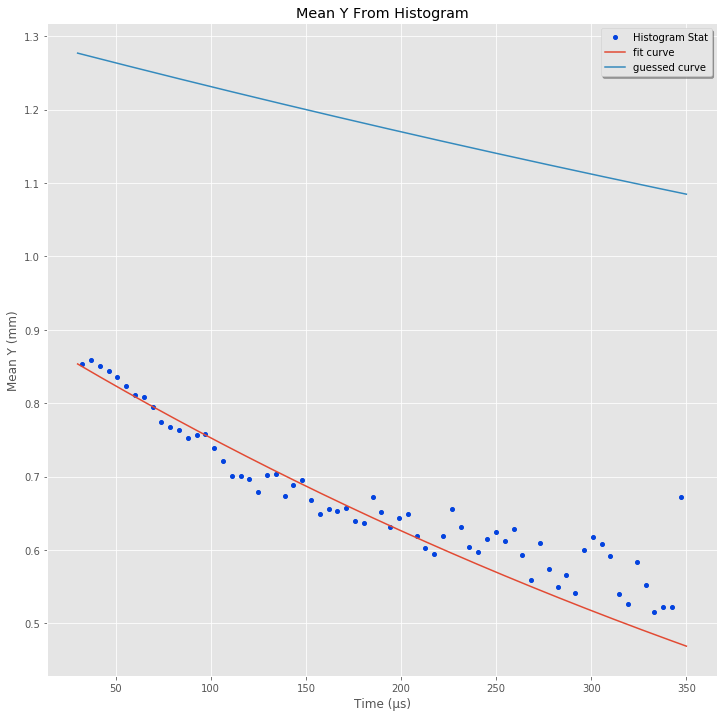

In [25]:
# testing
plot_calo_means(gaus_fit(calo_hists[10], step=1, no_spikes=True), 'test', mean_lim=[None, None], fit_lim=[30, 350])

## Calculations Functions

In [10]:
def periodic(x, a, b, c, d):
    return a * np.exp(x / b) * np.cos(c * x + d)
    #return a * np.cos(c * x + d)

In [11]:
def reject(y, p):
    dec = abs(y[0] % 1)
    if( dec  < 0.6 and 0.4 < dec ):
        r.TF1.RejectPoint()
        return 0
    else:
        return p[0]*math.exp(-((y[0]-p[1])**2)/(2*(p[2]**2)))

In [12]:
def gaus_fit(hist, step=1, no_spikes=True):
    """
    Performs a Gaussian fit on the distribution of Y hits for a time slice
    
    hist: [TH2D] a histogram containing the y(t) data
    step: [int] the size of each bin for fitting
    no_spikes: [bool] if spikes should be removed. Defaults to False
    """
    stats = []
    
    for index in range(0, hist.GetNbinsX()-step, step):
        a = dict()
        try:
            proj = hist.ProjectionY("_py", index, index+step)
            the_fit = proj.Fit("gaus", "SNQ")
            
            a['TimeBin']      = index*(hist.GetXaxis().GetXmax()/hist.GetNbinsX())
            a['GausConst']    = the_fit.Parameter(0)
            a['GausMean']     = the_fit.Parameter(1)
            a['GausMeanError']= the_fit.Error(1)
            a['GausSD']       = the_fit.Parameter(2)
            a['GausSDError']  = the_fit.Error(2)
            a['ChiSquare']    = the_fit.Chi2() / the_fit.Ndf()
            
            a['HistMean']     = proj.GetMean()
            a['HistMeanError']= proj.GetMeanError()
            a['HistSD']       = proj.GetStdDev()
            a['HistSDError']  = proj.GetStdDevError()
            a['HistVar']      = proj.GetStdDev() ** 2
            a['HistVarError'] = 2 * abs(proj.GetStdDev()) * proj.GetStdDevError()
            a['Npoints']      = proj.GetEntries()
            a['RMS']          = proj.GetRMS()
            a['RMSError']     = proj.GetRMSError()
            a['Skewness']     = proj.GetSkewness()
                    
            if(no_spikes == True):
                func = r.TF1("func", reject, 0, 6, 3)
                func.SetParameters(1, 1, 1)
                the_fit_ns = proj.Fit(func, "SNQ")
                  
                a['GausConst_ns']     = the_fit_ns.Parameter(0)
                a['GausMean_ns']      = the_fit_ns.Parameter(1)
                a['GausMeanError_ns'] = the_fit_ns.Error(1)
                a['GausSD_ns']        = abs(the_fit_ns.Parameter(2))
                a['GausSDError_ns']   = the_fit_ns.Error(2)
                a['ChiSquare_ns']     = the_fit_ns.Chi2() / the_fit.Ndf()
                
            else:     # no_spikes == False
                a['GausConst_ns']     = 0
                a['GausMean_ns']      = 0
                a['GausMeanError_ns'] = 0
                a['GausSD_ns']        = 0
                a['ChiSquare_ns']     = 0
                
            stats.append(a)
                
        except:
            continue

    # print(stats)
    data = pd.DataFrame(columns=['TimeBin', 'GausConst', 'GausMean', 'GausMeanError',
                                 'GausSD', 'GausSDError', 'ChiSquare', 'HistMean',
                                 'HistMeanError', 'HistSD', 'HistSDError', 'HistVar',
                                 'HistVarError','Npoints', 'RMS',
                                 'Skewness', 'RMSError', 'GausConst_ns',
                                 'GausMean_ns', 'GausMeanError_ns',
                                 'GausSD_ns', 'GausSDError_ns', 'ChiSquare_ns'])
    
    for index in range(0, len(stats)):
        data.loc[index] = stats[index]
    
    return data

In [26]:
def get_calo_y_slope(data, fit_lim=[30, 200]):
    """
    
    """
    # convert from crystal units to mm
    
    data['HistMean']         = (data['HistMean'] - 3) * 25.2
    data['HistMeanError']    = data['HistMeanError'] * 25.2
   
    # restrict the data for fitting to be within a predefined time range
    fit_data = data[(data['TimeBin'] > fit_lim[0]) & (data['TimeBin'] < fit_lim[1])][:]
        
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1,
                            full=True, w=1/fit_data['HistMeanError'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1,
                            full=False, cov=True, w=1/fit_data['HistMeanError'])
        
    line = linear_func(coeff[0], coeff[1], fit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))
    
    # the slope corresponds to coeff[0]
    # the slope error corresponds to param_errors[0]
    
    return {'slope': coeff[0], 'error': param_errors[0], 'chi2': chisq_dof}

In [27]:
def get_calo_width_slope(data, fit_lim=[30, 200]):
    """
    
    """
    # convert from crystal units ^2 to mm^2
    
    data['HistVar']         = data['HistVar'] * 25.2 * 25.2
    data['HistVarError']    = data['HistVarError'] * 25.2 * 25.2
   
    # restrict the data for fitting to be within a predefined time range
    fit_data = data[(data['TimeBin'] > fit_lim[0]) & (data['TimeBin'] < fit_lim[1])][:]
        
    # I do not know why, but having both cov=True and full=True does not return cov
    stats_list = np.polyfit(fit_data['TimeBin'], fit_data['HistVar'], 1,
                            full=True, w=1/fit_data['HistVarError'])
    coeff, cov = np.polyfit(fit_data['TimeBin'], fit_data['HistVar'], 1,
                            full=False, cov=True, w=1/fit_data['HistVarError'])
        
    line = linear_func(coeff[0], coeff[1], fit_lim)
        
    # item [1] of stats_list is the fit residual
    chisq_dof = stats_list[1][0] / (len(fit_data['TimeBin']) - 2)
    param_errors = np.sqrt(np.diag(cov))
    
    # the slope corresponds to coeff[0]
    # the slope error corresponds to param_errors[0]
    
    return {'slope': coeff[0], 'error': param_errors[0], 'chi2': chisq_dof}

In [15]:
def linear_func(coef1, coef2, fit_lim):
    """
    Makes a numpy linspace of a linear function
    """
    
    x = np.linspace(fit_lim[0], fit_lim[1], 100*(fit_lim[1]-fit_lim[0]))
    y = coef1 * x + coef2
    
    return [x, y]

In [16]:
def exp_func(b, c, fit_lim):
    """
    Makes a numpy linspace of an exponential function
    """
    
    x = np.linspace(fit_lim[0], fit_lim[1], 100*(fit_lim[1] - fit_lim[0]))
    y = np.exp(-b * (x-30)) + c
    
    return [x, y]

In [17]:
def pow_func(a, b, c, fit_lim):
    x = np.linspace(fit_lim[0], fit_lim[1], 100*(fit_lim[1] - fit_lim[0]))
    y = a * x **(b) + c
    
    return [x, y]

In [18]:
def linear_func_scipy(x, a, b):
    return a * x + b

In [19]:
def exp_func_scipy(x, b, c):
    return np.exp(-b * (x-30)) + c

In [20]:
def pow_func_scipy(x, a, b, c):
    return a * x **(b) + c

## Mains

In [109]:
"""
Plot combined Quadrant widths and means
"""

step = 1

#plot_each_section_widths(get_sectional_data(quadrants, step), y_lim=[28, 30], name='quadrant')

plot_each_section_means(get_sectional_data(quadrants, step), y_lim=[0.6, 2.3], fit_lim=[30, 200], name='quadrant')

In [46]:
"""
Main fit result plotting

Run this to generate the graphs for the fit results per calorimeter
"""

fit_limits = [30, 200]
mean_limits = [30, 200]
sd_limits = [30, 300]
step = 1

pos_data = pd.DataFrame(columns = ['a', 'a error', 'b', 'b error', 'chi2'])
var_data = pd.DataFrame(columns = ['a', 'a error', 'b', 'b error', 'chi2'])

for num in range(0, len(calo_hists)):
    if (num < 9):
        pos_stats, var_stats = plot_hist_stats(gaus_fit(calo_hists[num], step, no_spikes=True), 'calo_0' + str(num + 1),
                                               mfit_lim=mean_limits, vfit_lim=sd_limits, fit_lim=fit_limits)
        
        pos_data.loc[num] = {'a':pos_stats[0], 'a error':pos_stats[1], 'b':pos_stats[2],
                             'b error':pos_stats[3], 'chi2':pos_stats[4]}
        var_data.loc[num] = {'a':var_stats[0], 'a error':var_stats[1], 'b':var_stats[2],
                             'b error':var_stats[3], 'chi2':var_stats[4]}
    else:
        pos_stats, var_stats = plot_hist_stats(gaus_fit(calo_hists[num], step, no_spikes=True), 'calo_' + str(num + 1),
                                               mfit_lim=mean_limits, vfit_lim=sd_limits, fit_lim=fit_limits)
        
        pos_data.loc[num] = {'a':pos_stats[0], 'a error':pos_stats[1], 'b':pos_stats[2],
                             'b error':pos_stats[3], 'chi2':pos_stats[4]}
        var_data.loc[num] = {'a':var_stats[0], 'a error':var_stats[1], 'b':var_stats[2],
                             'b error':var_stats[3], 'chi2':var_stats[4]}

pos_data.to_csv("yposition_data.csv")
var_data.to_csv("variance_data.csv")

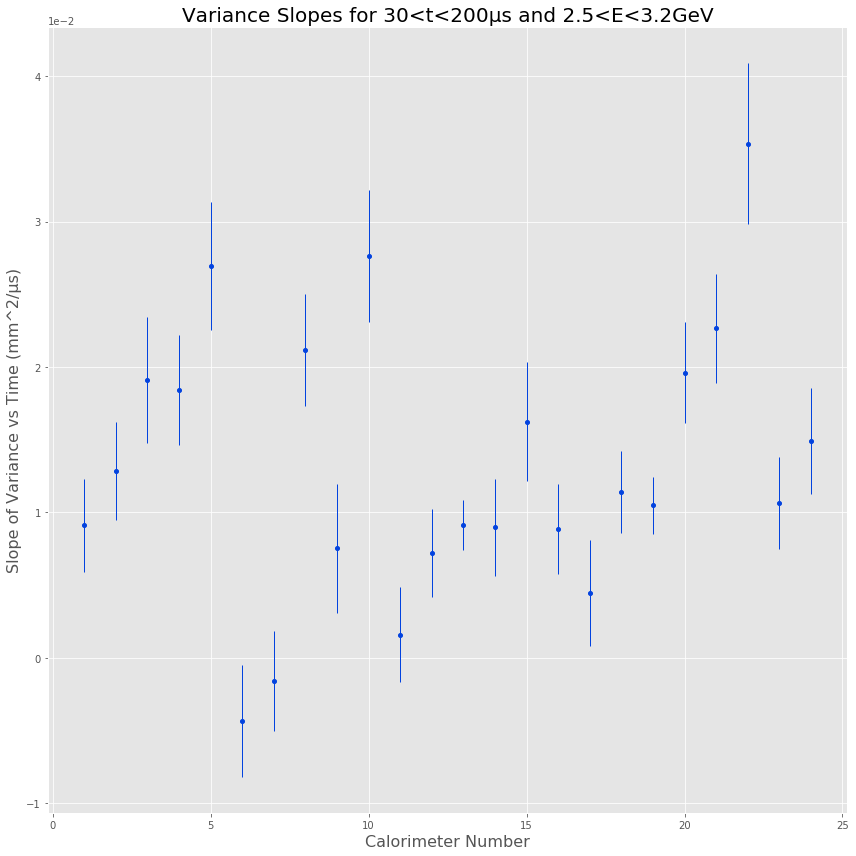

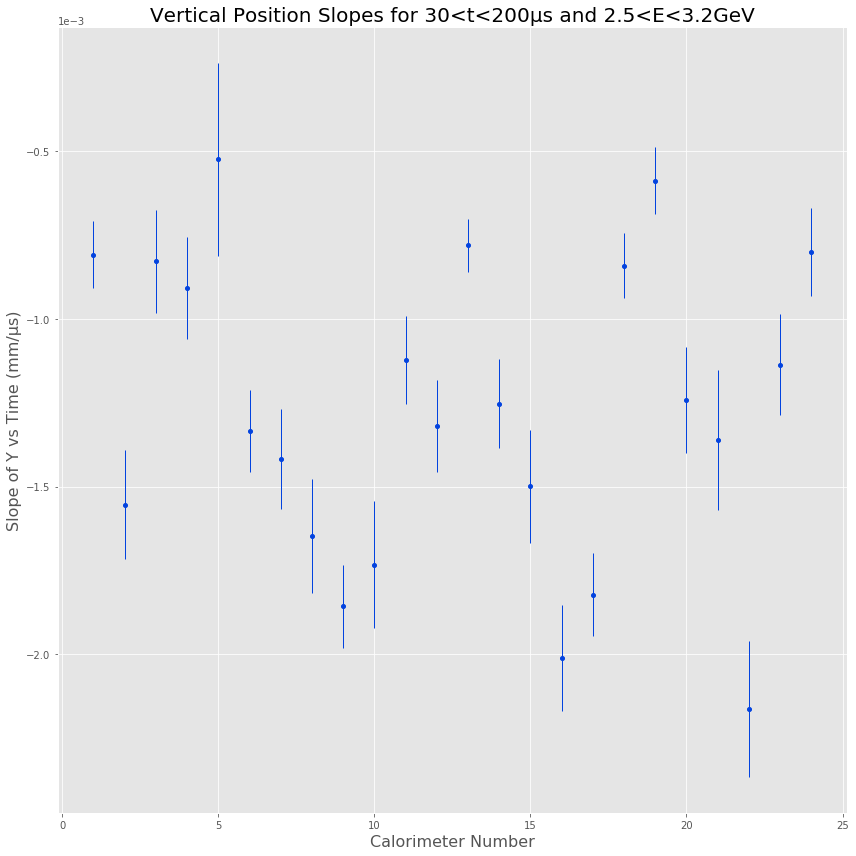

In [47]:
"""
Plot the slopes from each calo
"""

fit_limits = [30, 200]
step = 1

plot_width_per_calo(calo_hists, step)
plot_mean_per_calo(calo_hists, step)

## Testing

In [23]:
"""
Plot the functions for testing
"""
hist = create_hist(chain, "h", 1400, 1700, 2900, 1)

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


 FCN=10514.4 FROM MIGRAD    STATUS=CONVERGED     101 CALLS         102 TOTAL
                     EDM=6.43466e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.72293e+03   3.43186e+00   1.32942e-01  -4.20850e-05
   2  p1           3.00648e+00   2.26900e-03   1.13593e-04  -1.05979e-01
   3  p2           1.28161e+00   2.13373e-03   8.26481e-05   6.81899e-02


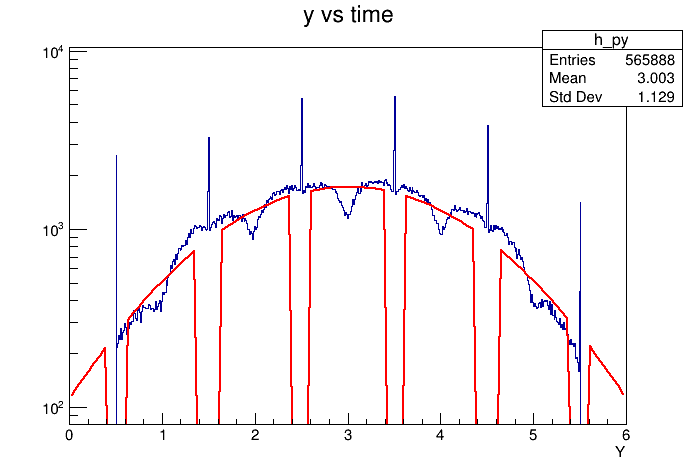

In [24]:
c = r.TCanvas()
proj = hist.ProjectionY("_py", 0, 50)
func = r.TF1("func", reject, 0, 6, 3)
func.SetParameters(4800, 3, 1)
#func.Draw()
proj.Draw()
proj.Fit(func, "")
c.SetLogy()
c.Draw()
c.Draw()


In [ ]:
data = gaus_fit(quadrants[0], 2, no_spikes=True)

fit_data = data[(data['TimeBin'] > 30) & (data['TimeBin'] < 250)][:]
        
coeff = np.polyfit(fit_data['TimeBin'], fit_data['HistMean'], 1, cov=True, full=True, w=1/fit_data['HistMeanError'])
#print(cov)
#print(np.sqrt(np.diag(cov)))
print(coeff)

In [60]:
h1 = quadrants[0].Clone("h1")
h3 = quadrants[2].Clone("h3")

print(h1.GetNbinsY())
print(h3.GetNbinsY())

600
600


In [36]:
# 149.2 ns Beam period; the time for one muon to travel the entire beam
# 4.365 μs Muon rotation period, the gap between peaks in wiggle curve

for i in range (0, 200):
    print('------------')
    print('muon   ' + str(i*4.365))
    print('beam   ' + str(i*149.2/1000))

------------
muon   0.0
beam   0.0
------------
muon   4.365
beam   0.1492
------------
muon   8.73
beam   0.2984
------------
muon   13.095
beam   0.44759999999999994
------------
muon   17.46
beam   0.5968
------------
muon   21.825000000000003
beam   0.746
------------
muon   26.19
beam   0.8951999999999999
------------
muon   30.555
beam   1.0443999999999998
------------
muon   34.92
beam   1.1936
------------
muon   39.285000000000004
beam   1.3428
------------
muon   43.650000000000006
beam   1.492
------------
muon   48.015
beam   1.6411999999999998
------------
muon   52.38
beam   1.7903999999999998
------------
muon   56.745000000000005
beam   1.9396
------------
muon   61.11
beam   2.0887999999999995
------------
muon   65.47500000000001
beam   2.238
------------
muon   69.84
beam   2.3872
------------
muon   74.205
beam   2.5363999999999995
------------
muon   78.57000000000001
beam   2.6856
------------
muon   82.935
beam   2.8347999999999995
------------
muon   87.30000000